In [1]:
import numba

In [266]:
import numpy as np, pandas as pd, datashader as ds
from datashader import transfer_functions as tf 
from datashader.colors import inferno, viridis
from numba import jit
from math import sin, cos, sqrt, fabs, tan, exp

In [249]:
#@jit
def Clifford(x,y,a,b,c,d,*o):
    return  sin(a * y) + c/d * cos(a**2 * x),\
                                           sin(b * x**2) + d/c * cos(b * y**2),\
#sin(b * x**2) + d/c * cos(b * y**2)

In [250]:
n= 10000000

#@jit
def trajectory(fn,x0,y0,a,b=0,c=0,d=0,e=0,f=0,n=n):
    x, y= np.zeros(n), np.zeros(n)
    x[0], y[0] = x0,y0
    for i in np.arange(n-1):
        x[i+1], y[i+1] = fn(x[i],y[i],a,b,c,d,e,f)
    return pd.DataFrame(dict(x=x,y=y))

In [251]:
#%%time
df = trajectory(Clifford, 0, 0,-1.3,-1.3,-1.8,-1.9)

In [252]:
df.tail()

,x,y
9999995,0.275778,0.965061
9999996,-0.104093,0.273186
9999997,0.585023,1.036506
9999998,-0.454314,-0.247498
9999999,0.997805,0.787097


In [253]:
cvs = ds.Canvas(plot_width = 700, plot_height = 700)
agg = cvs.points(df, 'x', 'y')
print(agg.values[190:195,190:195],"\n")

[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]] 



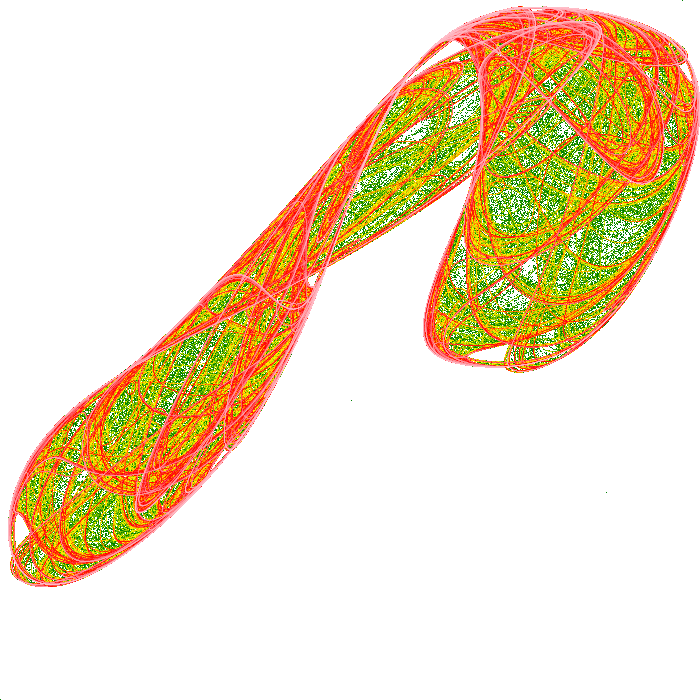

In [339]:
ds.transfer_functions.Image.border=0

tf.shade(agg, cmap = ["green", "yellow",'red','pink'])

In [217]:
def dsplot(fn, vals, n=n, cmap=viridis, label=True):
    """Return a Datashader image by collecting `n` trajectory points for the given attractor `fn`"""
    lab = ("{}, "*(len(vals)-1)+" {}").format(*vals) if label else None
    df  = trajectory(fn, *vals, n=n)
    cvs = ds.Canvas(plot_width = 300, plot_height = 300)
    agg = cvs.points(df, 'x', 'y')
    img = tf.shade(agg, cmap=cmap, name=lab)
    return img

In [218]:
from colorcet import palette
palette["viridis"]=viridis
palette["inferno"]=inferno

In [219]:
import yaml
vals = yaml.load(open("attractors.yml","r"))

def args(name):
    """Return a list of available argument lists for the given type of attractor"""
    return [v[1:] for v in vals if v[0]==name]

def plot(fn, vals=None, **kw):
    """Plot the given attractor `fn` once per provided set of arguments."""
    vargs=args(fn.__name__) if vals is None else vals
    return tf.Images(*[dsplot(fn, v[1:], cmap=palette[v[0]][::-1], **kw) for v in vargs]).cols(4)

FileNotFoundError: [Errno 2] No such file or directory: 'attractors.yml'

In [19]:
import numpy.random
numpy.random.seed(21)
num = 4

rvals=np.c_[np.zeros((num,2)), numpy.random.random((num,4))*4-2]
plot(Clifford, vals=[["kbc"]+list(rvals[i]) for i in range(len(rvals))], label=True)

NameError: name 'plot' is not defined

In [18]:
def De_Jong(x, y, a, b, c, d, *o):
    return sin(a * y) - cos(b * x), \
           sin(c * x) - cos(d * y)

plot(De_Jong)

NameError: name 'plot' is not defined

In [94]:
import matplotlib
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
plt.style.use('fivethirtyeight')
warnings.filterwarnings("ignore")
import sys

print(f"Python version: {sys.version}")
print(f"Numpy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Datashader version: {ds.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")

Python version: 3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 
[GCC 7.3.0]
Numpy version: 1.16.2
Pandas version: 0.24.2
Datashader version: 0.7.0
Matplotlib version: 2.2.3


In [333]:
# image size
width = 1000
height = 800

# number of steps
n = 100000000

# colormap
purples = plt.get_cmap('cet_rainbow_bgyrm_35_85_c71')

In [340]:
@jit
def hopalong_1(x, y, a, b, c):
    return y - np.sqrt(np.fabs(b * x - c)) * np.sign(x), \
           a**2 - x

@jit
def hopalong_2(x, y, a, b, c):
    return y - 1.0 - np.sqrt(np.fabs(b * x - np.pi - c/b)) * np.sign(x - 1.0), \
           a - x - 2.0 + b**3

@jit
def hopalong_3(x, y, a, b, c):
    return y - 3.0 - np.sqrt(np.fabs(a * x/b - 1000.0 - c**2)) * np.sign(x - 1.0), \
           b + exp(2) - x - 2.0
@jit
def G(x, mu):
    return mu * x + 2 * (1 - mu) * x**2 / (1.0 + x**2)


@jit
def Gumowski_Mira(x, y, a, b, mu, *o):
    xn = y + a*(1 - b*y**2)*y  +  G(x, mu)
    yn = -x + G(xn, mu)
    return xn, yn

In [341]:

def trajectory(fn, a, b, c, x0=0, y0=0, n=n):
    x, y = np.zeros(n), np.zeros(n)
    x[0], y[0] = x0, y0
    for i in np.arange(n-1):
        x[i+1], y[i+1] = fn(x[i], y[i], a, b, c)
    return pd.DataFrame(dict(x=x,y=y))

In [342]:
cvs = ds.Canvas(plot_width=width, plot_height=height)

def compute_and_plot(fn, a, b, c):
    df = trajectory(fn, a, b, c)
    agg = cvs.points(df, 'x', 'y')
    return tf.Images(tf.shade(agg, cmap=['red','green','yellow','pink']))

In [ ]:
ds.transfer_functions.Image.border=0
%time compute_and_plot(hopalong_2, -4.0, 0.09, 0.056)

CPU times: user 4min 28s, sys: 14.2 s, total: 4min 43s
Wall time: 4min 41s


CPU times: user 25.9 s, sys: 1.56 s, total: 27.5 s
Wall time: 27.3 s


""

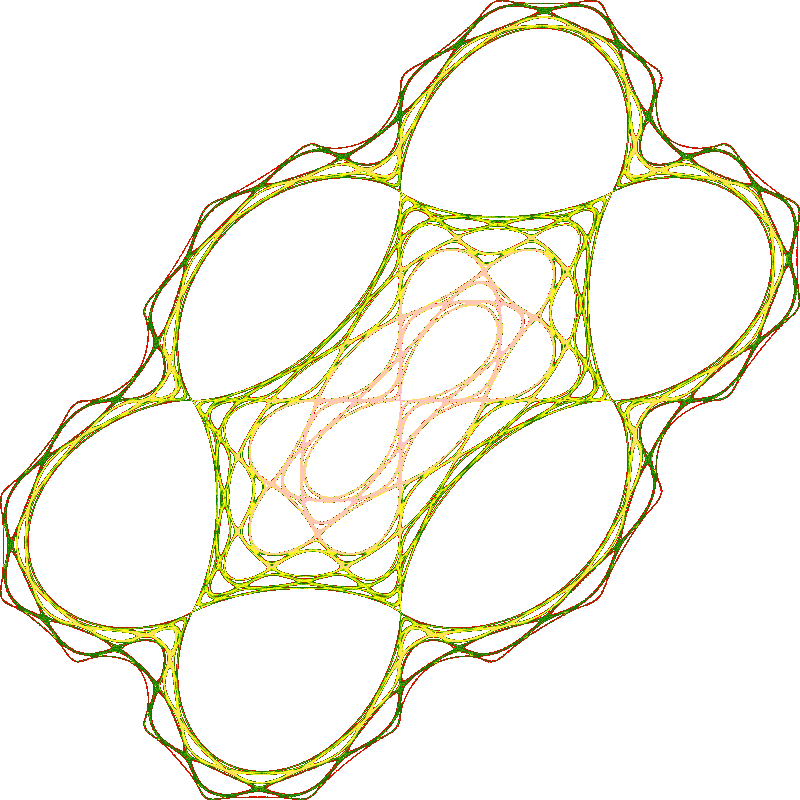

In [300]:
%time compute_and_plot(hopalong_3, 10000000.1*np.pi**3, 2000.09, np.pi)
#compute_and_plot(hopalong_2, -4.0, 0.09, 0.05)

In [274]:
th =plt.get_cmap('hh')

ValueError: Colormap hh is not recognized. Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cet_CET_C1, cet_CET_C1_r, cet_CET_C1s, cet_CET_C1s_r, cet_CET_C2, cet_CET_C2_r, cet_CET_C2s, cet_CET_C2s_r, cet_CET_C4, cet_CET_C4_r, cet_CET_C4s, cet_CET_C4s_r, cet_CET_C5, cet_CET_C5_r, cet_CET_C5s, cet_CET_C5s_r, cet_CET_CBC1, cet_CET_CBC1_r, cet_CET_CBC2, cet_CET_CBC2_r, cet_CET_CBD1, cet_CET_CBD1_r, cet_CET_CBL1, cet_CET_CBL1_r, cet_CET_CBL2, cet_CET_CBL2_r, cet_CET_CBTC1, cet_CET_CBTC1_r, cet_CET_CBTC2, cet_CET_CBTC2_r, cet_CET_CBTD1, cet_CET_CBTD1_r, cet_CET_CBTL1, cet_CET_CBTL1_r, cet_CET_CBTL2, cet_CET_CBTL2_r, cet_CET_D1, cet_CET_D10, cet_CET_D10_r, cet_CET_D11, cet_CET_D11_r, cet_CET_D12, cet_CET_D12_r, cet_CET_D13, cet_CET_D13_r, cet_CET_D1A, cet_CET_D1A_r, cet_CET_D1_r, cet_CET_D2, cet_CET_D2_r, cet_CET_D3, cet_CET_D3_r, cet_CET_D4, cet_CET_D4_r, cet_CET_D6, cet_CET_D6_r, cet_CET_D7, cet_CET_D7_r, cet_CET_D8, cet_CET_D8_r, cet_CET_D9, cet_CET_D9_r, cet_CET_I1, cet_CET_I1_r, cet_CET_I2, cet_CET_I2_r, cet_CET_I3, cet_CET_I3_r, cet_CET_L1, cet_CET_L10, cet_CET_L10_r, cet_CET_L11, cet_CET_L11_r, cet_CET_L12, cet_CET_L12_r, cet_CET_L13, cet_CET_L13_r, cet_CET_L14, cet_CET_L14_r, cet_CET_L15, cet_CET_L15_r, cet_CET_L16, cet_CET_L16_r, cet_CET_L17, cet_CET_L17_r, cet_CET_L18, cet_CET_L18_r, cet_CET_L19, cet_CET_L19_r, cet_CET_L1_r, cet_CET_L2, cet_CET_L2_r, cet_CET_L3, cet_CET_L3_r, cet_CET_L4, cet_CET_L4_r, cet_CET_L5, cet_CET_L5_r, cet_CET_L6, cet_CET_L6_r, cet_CET_L7, cet_CET_L7_r, cet_CET_L8, cet_CET_L8_r, cet_CET_L9, cet_CET_L9_r, cet_CET_R1, cet_CET_R1_r, cet_CET_R2, cet_CET_R2_r, cet_CET_R3, cet_CET_R3_r, cet_bgy, cet_bgy_r, cet_bgyw, cet_bgyw_r, cet_bjy, cet_bjy_r, cet_bkr, cet_bkr_r, cet_bky, cet_bky_r, cet_blues, cet_blues_r, cet_bmw, cet_bmw_r, cet_bmy, cet_bmy_r, cet_bwy, cet_bwy_r, cet_colorwheel, cet_colorwheel_r, cet_coolwarm, cet_coolwarm_r, cet_cwr, cet_cwr_r, cet_cyclic_grey_15_85_c0, cet_cyclic_grey_15_85_c0_r, cet_cyclic_grey_15_85_c0_s25, cet_cyclic_grey_15_85_c0_s25_r, cet_cyclic_mrybm_35_75_c68, cet_cyclic_mrybm_35_75_c68_r, cet_cyclic_mrybm_35_75_c68_s25, cet_cyclic_mrybm_35_75_c68_s25_r, cet_cyclic_mygbm_30_95_c78, cet_cyclic_mygbm_30_95_c78_r, cet_cyclic_mygbm_30_95_c78_s25, cet_cyclic_mygbm_30_95_c78_s25_r, cet_cyclic_protanopic_deuteranopic_bwyk_16_96_c31, cet_cyclic_protanopic_deuteranopic_bwyk_16_96_c31_r, cet_cyclic_protanopic_deuteranopic_wywb_55_96_c33, cet_cyclic_protanopic_deuteranopic_wywb_55_96_c33_r, cet_cyclic_tritanopic_cwrk_40_100_c20, cet_cyclic_tritanopic_cwrk_40_100_c20_r, cet_cyclic_tritanopic_wrwc_70_100_c20, cet_cyclic_tritanopic_wrwc_70_100_c20_r, cet_cyclic_wrwbw_40_90_c42, cet_cyclic_wrwbw_40_90_c42_r, cet_cyclic_wrwbw_40_90_c42_s25, cet_cyclic_wrwbw_40_90_c42_s25_r, cet_dimgray, cet_dimgray_r, cet_diverging_bkr_55_10_c35, cet_diverging_bkr_55_10_c35_r, cet_diverging_bky_60_10_c30, cet_diverging_bky_60_10_c30_r, cet_diverging_bwg_20_95_c41, cet_diverging_bwg_20_95_c41_r, cet_diverging_bwr_20_95_c54, cet_diverging_bwr_20_95_c54_r, cet_diverging_bwr_40_95_c42, cet_diverging_bwr_40_95_c42_r, cet_diverging_bwr_55_98_c37, cet_diverging_bwr_55_98_c37_r, cet_diverging_cwm_80_100_c22, cet_diverging_cwm_80_100_c22_r, cet_diverging_gkr_60_10_c40, cet_diverging_gkr_60_10_c40_r, cet_diverging_gwr_55_95_c38, cet_diverging_gwr_55_95_c38_r, cet_diverging_gwv_55_95_c39, cet_diverging_gwv_55_95_c39_r, cet_diverging_isoluminant_cjm_75_c23, cet_diverging_isoluminant_cjm_75_c23_r, cet_diverging_isoluminant_cjm_75_c24, cet_diverging_isoluminant_cjm_75_c24_r, cet_diverging_isoluminant_cjo_70_c25, cet_diverging_isoluminant_cjo_70_c25_r, cet_diverging_linear_bjr_30_55_c53, cet_diverging_linear_bjr_30_55_c53_r, cet_diverging_linear_bjy_30_90_c45, cet_diverging_linear_bjy_30_90_c45_r, cet_diverging_protanopic_deuteranopic_bwy_60_95_c32, cet_diverging_protanopic_deuteranopic_bwy_60_95_c32_r, cet_diverging_rainbow_bgymr_45_85_c67, cet_diverging_rainbow_bgymr_45_85_c67_r, cet_diverging_tritanopic_cwr_75_98_c20, cet_diverging_tritanopic_cwr_75_98_c20_r, cet_fire, cet_fire_r, cet_glasbey, cet_glasbey_bw, cet_glasbey_bw_minc_20, cet_glasbey_bw_minc_20_hue_150_280, cet_glasbey_bw_minc_20_hue_150_280_r, cet_glasbey_bw_minc_20_hue_330_100, cet_glasbey_bw_minc_20_hue_330_100_r, cet_glasbey_bw_minc_20_maxl_70, cet_glasbey_bw_minc_20_maxl_70_r, cet_glasbey_bw_minc_20_minl_30, cet_glasbey_bw_minc_20_minl_30_r, cet_glasbey_bw_minc_20_r, cet_glasbey_bw_r, cet_glasbey_category10, cet_glasbey_category10_r, cet_glasbey_cool, cet_glasbey_cool_r, cet_glasbey_dark, cet_glasbey_dark_r, cet_glasbey_hv, cet_glasbey_hv_r, cet_glasbey_light, cet_glasbey_light_r, cet_glasbey_r, cet_glasbey_warm, cet_glasbey_warm_r, cet_gray, cet_gray_r, cet_gwv, cet_gwv_r, cet_isolum, cet_isolum_r, cet_isoluminant_cgo_70_c39, cet_isoluminant_cgo_70_c39_r, cet_isoluminant_cgo_80_c38, cet_isoluminant_cgo_80_c38_r, cet_isoluminant_cm_70_c39, cet_isoluminant_cm_70_c39_r, cet_kb, cet_kb_r, cet_kbc, cet_kbc_r, cet_kg, cet_kg_r, cet_kgy, cet_kgy_r, cet_kr, cet_kr_r, cet_linear_bgy_10_95_c74, cet_linear_bgy_10_95_c74_r, cet_linear_bgyw_15_100_c67, cet_linear_bgyw_15_100_c67_r, cet_linear_bgyw_15_100_c68, cet_linear_bgyw_15_100_c68_r, cet_linear_bgyw_20_98_c66, cet_linear_bgyw_20_98_c66_r, cet_linear_blue_5_95_c73, cet_linear_blue_5_95_c73_r, cet_linear_blue_95_50_c20, cet_linear_blue_95_50_c20_r, cet_linear_bmw_5_95_c86, cet_linear_bmw_5_95_c86_r, cet_linear_bmw_5_95_c89, cet_linear_bmw_5_95_c89_r, cet_linear_bmy_10_95_c71, cet_linear_bmy_10_95_c71_r, cet_linear_bmy_10_95_c78, cet_linear_bmy_10_95_c78_r, cet_linear_gow_60_85_c27, cet_linear_gow_60_85_c27_r, cet_linear_gow_65_90_c35, cet_linear_gow_65_90_c35_r, cet_linear_green_5_95_c69, cet_linear_green_5_95_c69_r, cet_linear_grey_0_100_c0, cet_linear_grey_0_100_c0_r, cet_linear_grey_10_95_c0, cet_linear_grey_10_95_c0_r, cet_linear_kbc_5_95_c73, cet_linear_kbc_5_95_c73_r, cet_linear_kbgyw_5_98_c62, cet_linear_kbgyw_5_98_c62_r, cet_linear_kgy_5_95_c69, cet_linear_kgy_5_95_c69_r, cet_linear_kry_0_97_c73, cet_linear_kry_0_97_c73_r, cet_linear_kry_5_95_c72, cet_linear_kry_5_95_c72_r, cet_linear_kry_5_98_c75, cet_linear_kry_5_98_c75_r, cet_linear_kryw_0_100_c71, cet_linear_kryw_0_100_c71_r, cet_linear_kryw_5_100_c64, cet_linear_kryw_5_100_c64_r, cet_linear_kryw_5_100_c67, cet_linear_kryw_5_100_c67_r, cet_linear_protanopic_deuteranopic_kbjyw_5_95_c25, cet_linear_protanopic_deuteranopic_kbjyw_5_95_c25_r, cet_linear_protanopic_deuteranopic_kbw_5_98_c40, cet_linear_protanopic_deuteranopic_kbw_5_98_c40_r, cet_linear_ternary_blue_0_44_c57, cet_linear_ternary_blue_0_44_c57_r, cet_linear_ternary_green_0_46_c42, cet_linear_ternary_green_0_46_c42_r, cet_linear_ternary_red_0_50_c52, cet_linear_ternary_red_0_50_c52_r, cet_linear_tritanopic_krjcw_5_95_c24, cet_linear_tritanopic_krjcw_5_95_c24_r, cet_linear_tritanopic_krjcw_5_98_c46, cet_linear_tritanopic_krjcw_5_98_c46_r, cet_linear_wcmr_100_45_c42, cet_linear_wcmr_100_45_c42_r, cet_linear_worb_100_25_c53, cet_linear_worb_100_25_c53_r, cet_linear_wyor_100_45_c55, cet_linear_wyor_100_45_c55_r, cet_rainbow, cet_rainbow_bgyr_35_85_c72, cet_rainbow_bgyr_35_85_c72_r, cet_rainbow_bgyr_35_85_c73, cet_rainbow_bgyr_35_85_c73_r, cet_rainbow_bgyrm_35_85_c69, cet_rainbow_bgyrm_35_85_c69_r, cet_rainbow_bgyrm_35_85_c71, cet_rainbow_bgyrm_35_85_c71_r, cet_rainbow_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, magma, magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, viridis, viridis_r, vlag, vlag_r, winter, winter_r

In [152]:
Gumowski_Mira(x, y, a, b, mu, *o)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'line',
 'points',
 'raster',
 'trimesh',
 'validate']